In [43]:
from tensorflow.keras.datasets import mnist
import tensorflow

(X_train, y_train), (X_test, y_test) = mnist.load_data()

NUMBER_OF_IMAGES = X_train.shape[0]
BATCH_SIZE = 256


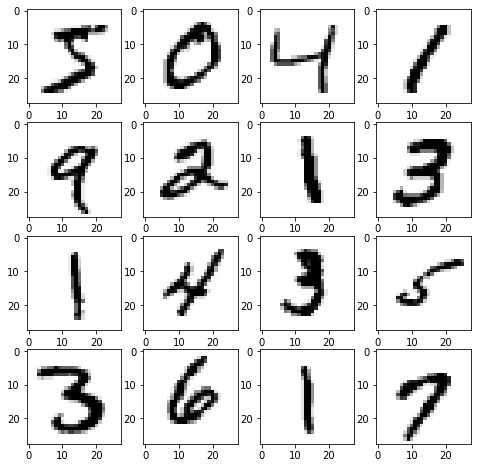

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i], cmap='gray_r')
plt.show()


In [45]:
X_train = X_train.reshape(NUMBER_OF_IMAGES, 28, 28, 1).astype('float32')
X_train = (X_train - 127.5)/127.5
X_train = tensorflow.data.Dataset.from_tensor_slices(
    X_train).shuffle(NUMBER_OF_IMAGES).batch(BATCH_SIZE)


In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Reshape, Dense, BatchNormalization, Conv2DTranspose, LeakyReLU


def Generator():
    model = Sequential()

    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(Conv2DTranspose(128, (5, 5), strides=(
        1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(
        2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2),
              padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


generator = Generator()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

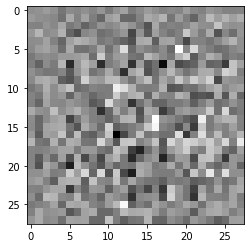

In [47]:
noise = tensorflow.random.normal([1, 100])

generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [3]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten


def Discriminator():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
              input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = Discriminator()

discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [49]:
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.50014424]], shape=(1, 1), dtype=float32)


In [50]:
from tensorflow.keras.losses import BinaryCrossentropy
cross_entropy = BinaryCrossentropy(from_logits=True)


In [60]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tensorflow.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tensorflow.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [61]:
def generator_loss(fake_output):
    return cross_entropy(tensorflow.ones_like(fake_output), fake_output)


In [62]:
from tensorflow.keras.optimizers import Adam
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)


In [63]:
from tensorflow.train import Checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = Checkpoint(generator_optimizer=generator_optimizer,
                        discriminator_optimizer=discriminator_optimizer,
                        generator=generator,
                        discriminator=discriminator)


In [69]:
from tensorflow.random import normal
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = normal([num_examples_to_generate, noise_dim])


In [70]:
from tensorflow import function, GradientTape
from tensorflow.random import normal
GENERATOR_LOSS = []
DISCRIMINATOR_LOSS = []

@function
def train_step(images):
    noise = normal([BATCH_SIZE, noise_dim])
    with GradientTape() as gen_tape, GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        GENERATOR_LOSS.append(gen_loss.numpy())
        disc_loss = discriminator_loss(real_output, fake_output)
        DISCRIMINATOR_LOSS.append(disc_loss.numpy())

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))


In [71]:
import time
from IPython import display


def train(dataset, epochs):
    j = 0
    for epoch in range(epochs):
        start = time.time()
        print(f"Epoch {j}")
        j = j+1
        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


In [72]:
def generate_and_save_images(model, epoch, test_input):
    
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


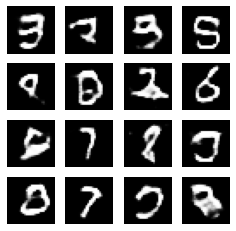

In [75]:
train(X_train, EPOCHS)


In [76]:
from tensorflow.train import latest_checkpoint
checkpoint.restore(latest_checkpoint(checkpoint_dir))


In [79]:
import PIL


def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


1.3522363

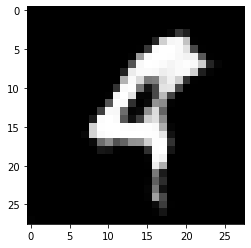

In [198]:
noise = tensorflow.random.normal([1, 100])

generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

fake_output = discriminator(generated_image, training=False)

gen_loss = generator_loss(fake_output)
gen_loss.numpy()


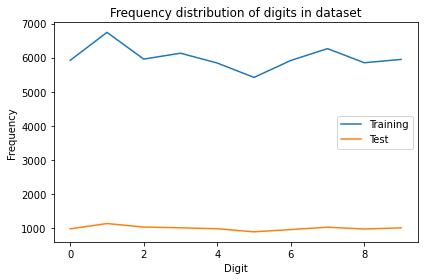

In [142]:
import pandas as pd
TRAINING_DATA = pd.DataFrame(y_train)[0].value_counts().sort_index()
TEST_DATA = pd.DataFrame(y_test)[0].value_counts().sort_index()
plt.plot(TRAINING_DATA)
plt.plot(TEST_DATA)
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Frequency distribution of digits in dataset')
plt.tight_layout()
plt.legend(['Training', 'Test'])


In [144]:
TRAINING_DATA.sort_values()


5    5421
4    5842
8    5851
6    5918
0    5923
9    5949
2    5958
3    6131
7    6265
1    6742
Name: 0, dtype: int64

In [1]:
import tensorflow as tf

In [11]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]